<a href="https://www.kaggle.com/code/agastyapatel/01-fastaiintro?scriptVersionId=155239635" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
        
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogcat/dog_cat_test_01.jpg


# Installing Dependencies

In [2]:
!pip install -Uqq fastai fastbook duckduckgo_search
from fastbook import *

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Training Classification Model
We are creating classification model based on the [Oxford IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/).
Labelling is done by name (first letter caps for cats and vice versa)

In [3]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)/'images'
print(path)

# label function
def is_dog(x): return x[0].islower()

# Data loaders
dls = ImageDataLoaders.from_name_func(path, get_image_files(path),
                                      valid_pct=0.2, seed=42,
                                      label_func=is_dog, item_tfms=Resize(224))

print(dls)
# Training our image recognizer by asking fastai to create CNN 
# based on resnet pre-trained model which has been trained on 1.3 million images
# ResNet is made with Deep residual Network Architechture,
# data (dls) is used for transfer learning  
learn =  vision_learner(dls, resnet34, metrics=error_rate)

learn.fine_tune(1)

/root/.fastai/data/oxford-iiit-pet/images


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 258MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.125974,0.024228,0.006089,00:25


epoch,train_loss,valid_loss,error_rate,time
0,0.056890,0.019104,0.005413,00:23


In [4]:
uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

**Uploading data doesn't work through the above method in Kaggle**

Instead use Dataupload in Sidebar and copy the file path

/kaggle/input/dogcat/dog_cat_test_01.jpg


True tensor(1) tensor([0.0374, 0.9626])


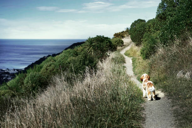

In [5]:
uploader = SimpleNamespace(data=['/kaggle/input/dogcat/dog_cat_test_01.jpg'])
print(uploader.data[0])
img = PILImage.create(uploader.data[0])
is_dog,_,probs = learn.predict(img)
print(is_dog, _, probs)
img.to_thumb(192)

## Is it a bird?

Downloading images

In [6]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

urls = search_images('bird photos', max_images=1)
print(type(urls))
print(urls[0])

Searching for 'bird photos'


/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:40: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")


<class 'fastcore.foundation.L'>
https://images.alphacoders.com/492/492674.jpg


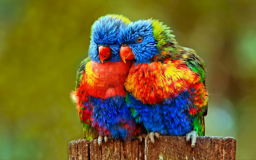

In [7]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0],dest, show_progress=True)

im = Image.open(dest)
im.to_thumb(256)

Searching for 'flamingo'


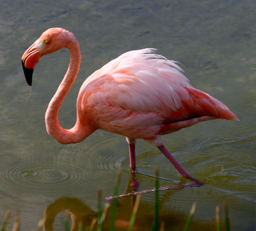

In [8]:
download_url(search_images('flamingo', max_images=1)[0], 'flamingo.jpg', show_progress=False)
Image.open('flamingo.jpg').to_thumb(256)

Searching for 'forest'


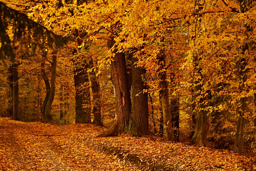

In [9]:
download_url(search_images('forest', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256)

In [10]:
searches = 'forest', 'bird'
path = Path('forest_or_not')
for o in searches:
    dest = path/o
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} images'))
    
    download_images(dest, urls=search_images(f'{o} sun photo'))
    
    download_images(dest, urls=search_images(f'{o} shade photo'))
    print(dest)

Searching for 'forest images'
Searching for 'forest sun photo'
Searching for 'forest shade photo'
forest_or_not/forest
Searching for 'bird images'
Searching for 'bird sun photo'
Searching for 'bird shade photo'
forest_or_not/bird


Deleting the photos which were not downloaded properlu


In [11]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

2

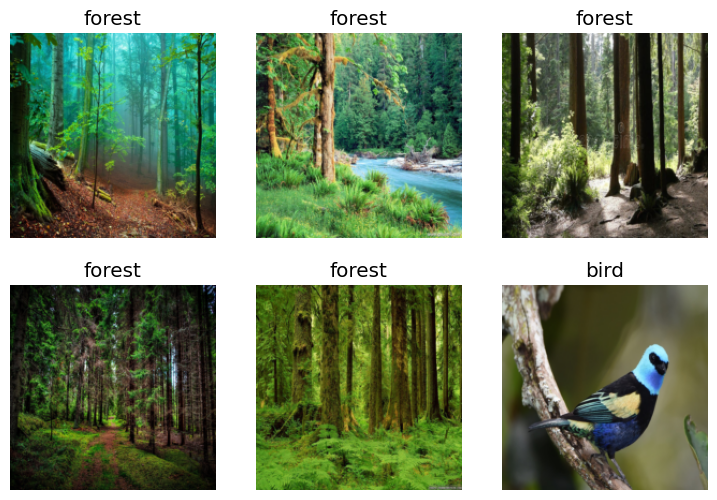

In [12]:
# DataLoaders Object contains training set and validation set
dls = DataBlock(blocks=(ImageBlock, CategoryBlock),               #Block inpuuts are Images, and outputs is categories
                get_items=get_image_files,                        #method to fetch items
                splitter=RandomSplitter(valid_pct=0.2, seed=42),  #split into training and validation set
                get_y=parent_label,                               #Label from name of Parent Folder 
                item_tfms=[Resize(192, method='squish')]          #transforms for each items
               ).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

fastai uses `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model.

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the pretrained model), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in imagenet, and widely-used computer vision dataset with images covering 1000 categories) 

In [13]:
# Training our model
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 215MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.926724,0.802507,0.303030,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.082337,0.044902,0.000000,00:10
1,0.051861,0.054143,0.030303,00:10
2,0.035204,0.093172,0.060606,00:11


### Testing the model

In [14]:
download_url('https://currumbinvetservices.com.au/wp-content/uploads/2023/01/bird-physiology.jpg', 'bird1.jpg')

Path('bird1.jpg')

In [15]:
for file in ['bird.jpg', 'bird1.jpg']:
    is_bird, _, probs = learn.predict(PILImage.create(file))
    print(is_bird, _, probs)

bird tensor(0) tensor([0.9951, 0.0049])


bird tensor(0) tensor([0.8104, 0.1896])


# Questionnaire

1. Do you need these for deep learning?

    - Lots of math: False
    - Lots of data: False
    - Lots of expensive computers: False
    - A PhD: False
2. Name five areas where deep learning is now the best in the world.
    - NLP: Speech Recognition, Speech-to-text
    - Medical: Diagnosis using Classification, Pattern Identification
    - Computer Vision: Object Recognition, Image Segmentation
    - Recommendation System: Content Recommendation, product recommendation
    - Pattern Identification and future prediction of Stock, forecast
3. What was the name of the first device that was based on the principle of the artificial neuron?
    - Mark I Perceptron

4. Based on the book of the same name, what are the requirements for parallel distributed processing (PDP)?
    - A set of processing units.
    - A state of activation
    - An output function for each unit
    - A pattern of connectivity among unit
    - A propogation rule for propagating patterns of activities through network of connectivities.
    - An activation rule for combining the inputs impinging on unit with the current state of that unit to produce a new level of activation for the unit.
    - A learning rule where patterns of connectivity are modified by experience.
    - An environment within which the system operates.

5. What were the two theoretical misunderstandings that held back the field of neural networks?
    - "Perceptron" when released conveyed the information that single layer of artificial neurons connot learn.
    - When multiple layers of neurons were laid in the network. It was able to approximate all mathematical function. However, it was quite slow, complex and big. 

6. What is a GPU?
    - Graphics Processing Unit. These are specialized units which are used for processing 3d Graphics. The hardware optimization used in GPU allows them to process thousands of small tasks at the same time which makes them perfect to run and train neural network.

7. Open a notebook and execute a cell containing: 1+1. What happens?
    - It prints 2

8. Follow through each cell of the stripped version of the notebook for this chapter. Before executing each cell, guess what will happen.
    - Done

9. Complete the Jupyter Notebook online appendix.
    - Done
10. Why is it hard to use a traditional computer program to recognize images in a photo?
    - It is difficult to replicate the exact conscious steps and create rules accordingly. Hence programming such computer program is difficult.
11. What did Samuel mean by "weight assignment"?
    - Weight Assignment refers to the current weight or value of the model parameter. Samuel also refers to creating a system for automatic weight assignment based on improving the performance of the model. 

12. What term do we normally use in deep learning for what Samuel called "weights"?
    - We use term 'parameters' instead of weight referred by Samuel.

13. Draw a picture that summarizes Samuel's view of a machine learning model.
    - Refer the book.

14. Why is it hard to understand why a deep learning model makes a particular prediction?
    - Working of deep learning is often refered to as 'Black Box' since no one understand what is actually happening inside of a model and how it is able to make predictions. It is because of their deep and complex network of nodes which act as a seperate decision unit. It is difficult to imagine working of all units at once as nuerons are interconnected and their activation depends on the output of the nuerons from the previous layer.

15. What is the name of the theorem that shows that a neural network can solve any mathematical problem to any level of accuracy?
    - Universal Approximation Theorem. It states that neural network can theoretically represent any mathematical function. It can provide solutions to task to very high accuracy.

16. What do you need in order to train a model?
    - Input for the model or Data.
    - Labels for the data which would be used during training.
    - Base achitechture on which the model will be build.
    - Loss function to identify the performance in terms of quantity.
    - Update Function which would be used to improve the performance of the model by modifying the value of parameters.

17. How could a feedback loop impact the rollout of a predictive policing model?
    - Incase of predictive policing, the model is actually not predicting the crimes but it's predicting the arrests.
    - With initial data of current arrests which is biased data (due to current policies) input for the model. 
    - The model would create a perception of targeting certain communities for the arrest because of the biased training data.
    - Model woul predict more arrests in that region leading more focused police activity in the region.
    - This would lead to more arrest and when model gets updated it would predict more arrests with greater confidence.

18. Do we always have to use 224×224-pixel images with the cat recognition model?
    - No, but it has been a common practice to use 224x224 pixel images as older models used to work on this resolution.

19. What is the difference between classification and regression?
    - Classification method makes predictions according to categories for that particular variable.
    - Regression method makes predictions according to real number for that variable. 

20. What is a validation set? What is a test set? Why do we need them?
    - Validation set is the subset of input data which has not been used for training. It is used to test the accuracy of the trained model.
    - Test Set is a different data set which has neither been used in training and validating the model. It provides additional method which can make sure that 

21. What will fastai do if you don't provide a validation set?
    - Sets 20% of the input/training data as validation set.

22. Can we always use a random sample for a validation set? Why or why not?
    - We should not us the random sample for validation set else it can lead to using of the training set during validation of model.
    - This would make our validation set random for each training that we lay and we might not be able to understand if the changes in the model is causing our results to vary.

23. What is overfitting? Provide an example.
    - Overfitting happens when model starts to memorize the data instead of learning the general features of the data and makes predictions based on it. Overfitting causes the model to work with almost 100% accuracy for the training data set but performs terrible with other data set like validation and test dataset.

24. What is a metric? How does it differ from "loss"?
    - Metric is a function that measures the quality of the model's prediction using the validation set. 
    - It is determined once in a EPOCH. Metrics are human-interpretable measures of performance.
    - Loss function also measures quality of the model. However, it is meant for optimizing the algorithm like SGD to efficiently update the model's parameters.

25. How can pretrained models help?
    - Pretrained models have already been trained on other similar problem with a possibility of covering a large usecase.
    - Pretrained model are useful because it reduces the time, memory, and cost of training.
    - Pretrained model are great because they already have the basic feature identification embedded in them which can be useful for our task usecase.
    
26. What is the "head" of a model?
    - When finetuning pretrained model, the process involves the removal of the later layers which were designed specifically for the orignal task and are replace with new set of layers with randomized weights, of nearly same size of the input dataset that you are working with.  
    - 'Head' of the model is the new sets of layers of the neural networks.

27. What kinds of features do the early layers of a CNN find? How about the later layers?
    - Early layers of CNN learns simple features like horizontal and vertical lines, diagonal lines, gradients.
    - Later layers contain advance features like car wheels, animals.

28. Are image models only useful for photos?
    - No, image models have been used to resolve many different problem. It has been used to identify the voice in spectrogram, recognize the malware.
    
29. What is an "architecture"?
    - It is a template or structure of the model we are trying to fit. It defines mathematical model we are trying to fit.
    
30. What is segmentation?
    - Segmentation is the process of pixelwise classification. We label every single pixel in the image. This provides a mask for which parts of the image correspond to the given label.
    
31. What is y_range used for? When do we need it?
    - y_range is used to limit the range of prediction for our regression based problems.
    
32. What are "hyperparameters"?
    - Training model requires different parameters which define how the model is trained.
    - Hyperparameters are parameters are used to set the overall model setting.
    
32. What's the best way to avoid failures when using AI in an organization?
    - We need to have training, validation, and testing set which would be used to 